In [7]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot import drot
from drot.proximal import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Optimal transport

In [3]:
def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)

    sigma = 0.1;

    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)

    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)

    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(n):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])
    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((n,)) / n, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()

    return n, C, p, q

Stepsize decreased, new value is  0.005
Stepsize decreased, new value is  0.0025
Stepsize decreased, new value is  0.00125
Stepsize decreased, new value is  0.000625
Stepsize decreased, new value is  0.0003125
Stepsize decreased, new value is  0.00015625
Solve time:  2.0644049644470215


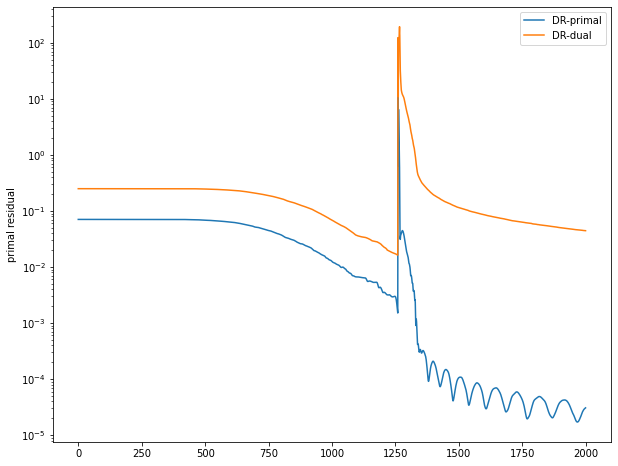

In [9]:
max_iters = 2000
step = 0.01

n, C, p, q = two_dimensional_gaussian_ot(400)
x0 = np.ones((n,n), order='F')/n

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x: generalized_doubly_stochastic_matrices_projection(x, p, q)
proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
proxh = lambda x, xnew, stz: primal_dual_linear_prox(x, xnew, p, q, stz)

drout  = drot(x0, proxf, proxg, np.vstack((p,q)), max_iters, step=step, relaxation=1.2, compute_r_primal=True,                         compute_r_dual=True, adapt_stepsize=True)
# cpout  = PDHG(x0, proxg_, proxh, max_iters, step=(1/(2*n))**0.5, relaxation=1.0)

xopt = drout["sol"]
# xopt_cp = cpout["sol"]

plt.figure(1, figsize=(10,8))
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='DR-primal')
plt.plot(range(drout["num_iters"]), [r for r in drout['dual']], label='DR-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

# plt.figure(2, figsize=(10,8))
# plt.plot(range(cpout["num_iters"]), [r for r in cpout['dual']], label='DR-dual')
# plt.ylabel("primal residual") 
# plt.yscale('log')
# plt.legend()

In [32]:
C_ = C.copy()
G0 = ot.emd(p, q, C_)
Gs = ot.sinkhorn(p, q, C_, 1e-3, verbose=False)
nla.norm(xopt.T - G0, ord='fro'),\
nla.norm(Gs - G0, ord='fro')

(0.03365894612042023, 0.030591086959056633)

In [33]:
np.trace(xopt.T.dot(C)), np.trace(G0.T.dot(C_)), np.trace(Gs.T.dot(C_))

(0.2602451068757028, 0.26016729117323434, 0.2610523146284066)

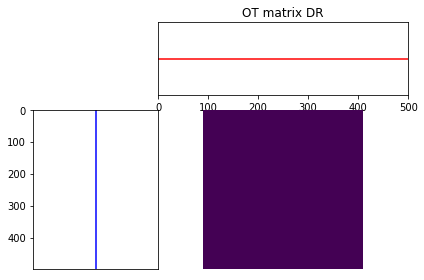

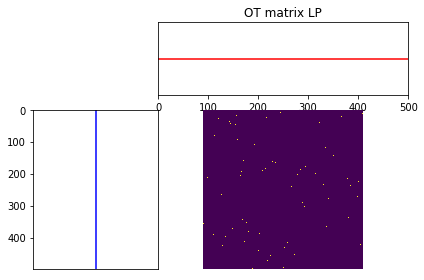

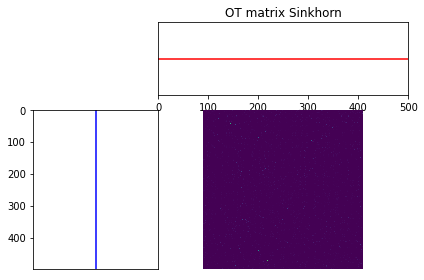

In [39]:
# G0 = ot.emd(p, q, C)

pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()

Text(0.5, 1.0, 'OT matrix Sinkhorn')

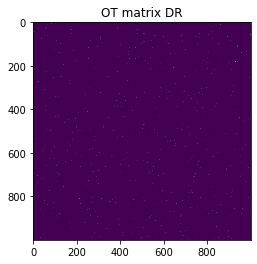

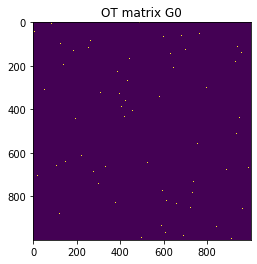

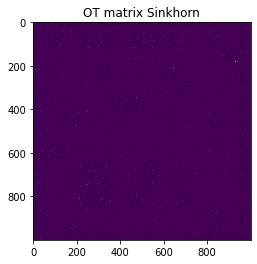

In [34]:
pl.figure(1)
pl.imshow(xopt, interpolation='nearest')
pl.title('OT matrix DR')

pl.figure(2)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(3)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix Sinkhorn')

In [47]:
import scipy
m, n = 10000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)

B = np.array(A, order='F')
assert np.allclose(A, B)

# def numpy_run1(A):
#     A_ = A.copy()
#     A_ += np.outer(x, y)

# def scipy_run(A):
#     B = np.array(A, order='F')
#     assert B.flags['F_CONTIGUOUS']
#     scipy.linalg.blas.dger(1, x, y, a=B, overwrite_a=1)

# f1 = lambda: numpy_run1(A)
# ts_md = timeit(f1, number=1)
# print(ts_md)

# f2 = lambda: scipy_run(B)
# ts_md = timeit(f2, number=1)
# print(ts_md)

# assert np.allclose(A, A_)

In [49]:
%timeit A.dot(y)

19.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
m, n = 5000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)
e = np.ones(n)
f = np.ones(m)

B = np.array(A, order='F')
C = np.zeros((m,n))

In [407]:
f1 = lambda: projection_1(A, s, r)
ts_md = timeit(f1, number=1)
print(ts_md)

f2 = lambda: projection_2(B, s, r)
ts_md = timeit(f2, number=1)
print(ts_md)


0.40367177900043316
0.10778809300245484


In [62]:
def Sinkhorn(C, reg, a, b, delta=1e-9, lam=1e-6):

    K = np.exp(-C / reg)
    u = np.ones(np.shape(a)[0])
    v = np.ones(np.shape(b)[0])

    u_trans = np.dot(K, v) + lam  # add regularization to avoid divide 0
    v_trans = np.dot(K.T, u) + lam  # add regularization to avoid divide 0

    err_1 = np.sum(np.abs(u * u_trans - a))
    err_2 = np.sum(np.abs(v * v_trans - b))

    while True:
        if err_1 + err_2 > delta:
            u = a / u_trans
            v_trans = np.dot(K.T, u) + lam

            v = b / v_trans
            u_trans = np.dot(K, v) + lam

            err_1 = np.sum(np.abs(u * u_trans - a))
            err_2 = np.sum(np.abs(v * v_trans - b))
        else:
            return u, v

def PDHG(init, proxg, proxh, max_iters=10, **kwargs):
    """
        min_x max_y <Ax, y> + g(x) - h(y) | x \in R^n, y \in R^m
    """
    step = kwargs.pop("step", 1.0)  
    eps_abs = kwargs.pop("eps_abs", 1e-6)   
    eps_rel = kwargs.pop("eps_rel", 1e-8)   
    lamda = kwargs.pop("relaxation", 1)
    verbose = kwargs.pop("verbose", False)
    print_every = kwargs.pop("print_every", 1)
    compute_r_primal = kwargs.pop("compute_r_primal", False)
    compute_r_dual = kwargs.pop("compute_r_dual", False)   
    adapt_stepsize = kwargs.pop("adapt_stepsize", True)
    incr = kwargs.pop("incr", 2.0)
    decr = kwargs.pop("decr", 2.0)
    mu = kwargs.pop("mu", 10.0)
    max_step = kwargs.pop("max_step", 1.0)
    min_step = kwargs.pop("min_step", 1e-4)

    assert (lamda > 0 and lamda < 2), "Relaxation parameter must be in (0,2)."

    if verbose:
        print("----------------------------------------------------")
        print(" iter | total res | primal res | dual res | time (s)")
        print("----------------------------------------------------")

    k = 0
    done = False
    x = np.array(init, order='F')
    y = np.zeros(x.shape[0] + x.shape[1])

    r_primal = np.zeros(max_iters)
    r_dual = np.zeros(max_iters)
        
    start = time()
    while not done:
        x_new = proxg(x, y, step)
        y += proxh(x, x_new, step)
        
        assert x.flags['F_CONTIGUOUS']   
        assert x_new.flags['F_CONTIGUOUS']   

        # r_primal[k] = nla.norm(x, ord=2)
        r_dual[k] = nla.norm(x_new  - x, ord='fro')
        res = np.sqrt((r_primal[k]**2 + r_dual[k]**2))

        x = x_new

        # res = 0
        if k == 0: 
            res0 = res
        
        if (k % print_every == 0 or k == max_iters-1) and verbose:
            print("{}| {}  {}  {}  {}".format(str(k).rjust(6), 
                                        format(res, ".2e").ljust(10),
                                        format(r_primal[k], ".2e").ljust(11), 
                                        format(r_dual[k], ".2e").ljust(9),
                                        format(time() - start, ".2e").ljust(8)))
        k += 1
        done = k >= max_iters or (res <= eps_abs + eps_rel * res0)
        
    end = time()
    print("Solve time: ", end - start)
    return {"sol": x, "primal": np.array(r_primal[:k]), "dual": np.array(r_dual[:k]), \
            "num_iters": k, "solve_time": (end - start)}

In [ ]:
# proxf_ = lambda x: nonneg_projection(x -  step * C_)
# proxg_ = lambda x: generalized_doubly_stochastic_matrices_projection_(x, p, q)